# SVD

SVD is a fundamental concept in linear algebra and numerical analysis. It's a matrix factorization method that breaks down a matrix into three simpler matrices. Given a matrix X, SVD is:
\begin{equation}
X = VDU^T,
\end{equation}
where $V$ and $U$ are orthogonal matrices of $n x n$ dimensions and consist of eigenvectors of $XX^T$ and $X^TX$ matrices respectively. $D$ consists of the square roots of the eigenvalues of $X^TX$.

$X^+ = (X^TX)^T X^T = UD^{-1}V^T$

Solving a linear equation using SVD provides the solution $W^* = X^+ Y$ with minimal Euclidean norm $||W||^2$ among all possible solutions.

Purpose of SVD:
SVD serves various purposes in different fields:

**Matrix Compression**: SVD can be used to approximate a matrix by keeping only the most important singular values and their corresponding vectors. This is particularly useful for dimensionality reduction and data compression.

**Matrix Approximation**: By truncating the singular value decomposition, we can approximate a matrix with a lower-rank approximation, which can be valuable for noise reduction or handling missing data.

**Solving Linear Systems**: SVD can help solve linear systems of equations by finding a least-squares solution when a system is overdetermined or inconsistent.

**Matrix Inversion**: SVD is used for computing the inverse of a matrix, especially when the matrix is not square or may be ill-conditioned.

**Principal Component Analysis (PCA)**: In data analysis, SVD is used in PCA to find the principal components of a dataset, which captures its most significant variations.

**Condition Number**:
The condition number of a matrix measures how sensitive the output of a problem is to changes in the input data. In the context of SVD, the condition number is used to assess how well-conditioned or ill-conditioned a matrix is. A lower condition number indicates better stability, while a higher condition number implies that small changes in the input data can result in large changes in the solution.



In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from mlxtend.plotting import plot_decision_regions

from torchvision import datasets
from torchvision import transforms

In [3]:
np.random.seed(0)
n = 2
l = 100
K = 2
beta= 0.

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)

y = X@W_true + beta*np.random.randn(l, K)

In [6]:
V, d, U = np.linalg.svd(X, full_matrices=False)

D = np.eye(len(d))*d
lambd = d**2

In [7]:
W = (U.T@np.linalg.inv(D)@V.T)@y

((W-W_true)**2).mean()

5.623715437610729e-32

### let's add some noise as beta

In [10]:
np.random.seed(0)
mus = np.linspace(0, 1, 10)
list_of_errors = []

for mu in mus:
    lambd_new = np.array(lambd)
    lambd_new[1] = mu*lambd_new[0]
    d_new = np.sqrt(lambd_new)
    D_new = np.eye(len(d_new))*d_new
    X_new = V@D_new@U
    
    y = X_new@W_true
    
    W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

    list_of_errors.append(((W-W_true)**2).mean())

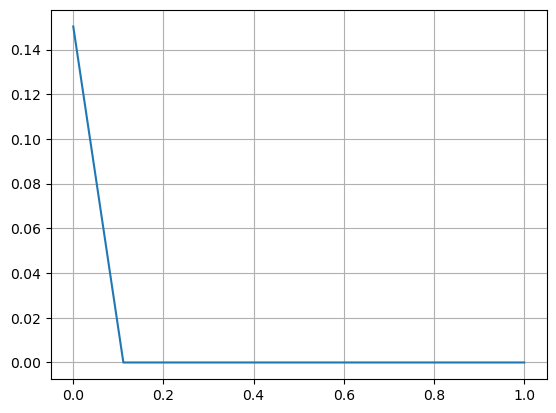

In [11]:
plt.plot(mus, list_of_errors)

plt.grid()
plt.show()

In [12]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu*lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U

        y = X_new@W_true + beta*np.random.randn(l, K)

        W = np.linalg.inv(X_new.T@X_new)@X_new.T@y

        list_of_errors[str(beta)][str(mu)] = ((W-W_true)**2).mean()

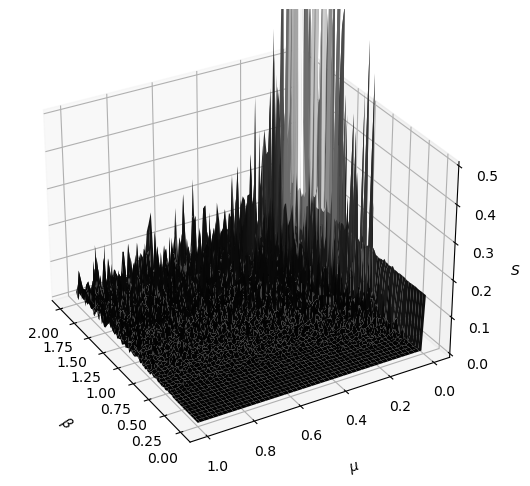

In [13]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]

fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad= 14), ax.set_ylabel(r'$\mu$', labelpad= 14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 0.5)), ax.view_init(30, 150)

plt.show()

### to cope with noise one can use regularization
$W^* = UD(D^2 + \tau I)^{-1}X^T Y$

In [16]:
np.random.seed(0)
n = 2
l = 100
K = 2

X = np.random.randn(l, n)
W_true = np.random.randn(n, K)


In [17]:
tau = 10.
W = (U.T@D@np.linalg.inv(D**2 + tau*np.eye(len(D)))@V.T)@y

((W-W_true)**2).mean()

0.022854848901753884

In [18]:
np.random.seed(0)
mus = np.linspace(0., 1., 100)
betas = np.linspace(0., 2., 100)
tau = 10.
list_of_errors = dict()

for beta in betas:
    list_of_errors[str(beta)] = dict()
    for mu in mus:
        lambd_new = np.array(lambd)
        lambd_new[1] = mu*lambd_new[0]
        d_new = np.sqrt(lambd_new)
        D_new = np.eye(len(d_new))*d_new
        X_new = V@D_new@U

        y = X_new@W_true + beta*np.random.randn(l, K)
        W = (U.T@D_new@np.linalg.inv(D_new**2 + tau*np.eye(len(D_new)))@V.T)@y

        list_of_errors[str(beta)][str(mu)] = ((W-W_true)**2).mean()

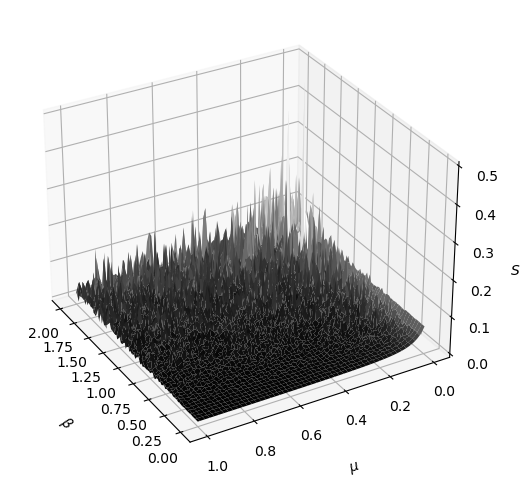

In [19]:
BETAS, MUS = np.meshgrid(betas, mus)
scores = np.zeros_like(BETAS)
for i in range(len(BETAS)):
    for j in range(len(BETAS[i])):
        scores[i][j] = list_of_errors[str(BETAS[i][j])][str(MUS[i][j])]

fig = plt.figure(figsize=(14.0, 6.0))
ax = plt.axes(projection='3d')
ax.plot_surface(BETAS, MUS, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$\beta$', labelpad= 14), ax.set_ylabel(r'$\mu$', labelpad= 14)
ax.set_zlabel(r'$S$'), ax.set_zlim((0, 0.5)), ax.view_init(30, 150)

plt.show()

### PCA

is the metthod wheen we choose new features with lower dimension that guarantee old feature recovery linearly

In [20]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True)
X_train = MNIST_train.data.view([-1, 784]).cpu().numpy()
Y_train = MNIST_train.targets.cpu().numpy()

MNIST_test = datasets.MNIST('./mnist', train=False, download=True)
X_test = MNIST_test.data.view([-1, 784]).cpu().numpy()
Y_test = MNIST_test.targets.cpu().numpy()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [21]:
pca = PCA(2)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.fit_transform(X_test)

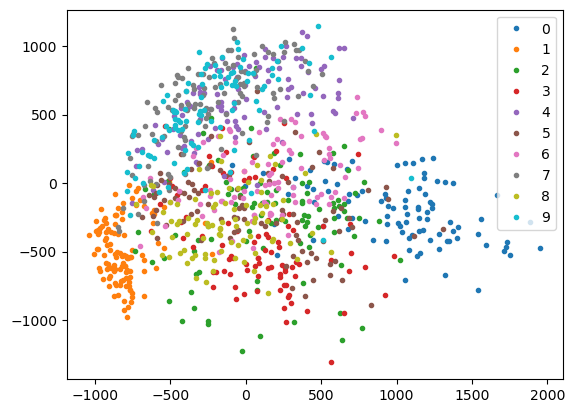

In [22]:
for k in np.unique(Y_train):
    idx = np.where(Y_train[:1000] == k)[0]
    plt.plot(X_train_low[idx, 0], X_train_low[idx, 1], '.', label = str(k))
    
plt.legend(loc='best')
plt.show()

In [23]:
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0, device='cpu'):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        self.to(device)
        
    def forward(self, input):
        return self.layers(input)
    
def trainer(model, dataset, loss_function, optimizer, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, 
                                              shuffle=True)
        for x, y in tqdm(generator, leave=False):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            
            
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)

    pred = []
    real = []
    for x, y in tqdm(generator, leave=False):
        x = x.to(device)
        y = y.to(device)

        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())

    return np.mean(np.array(real) == np.array(pred)), \
           classification_report(real, pred)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [25]:
model = Perceptron(device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.93      0.99      0.96      1135
           2       0.90      0.85      0.87      1032
           3       0.78      0.93      0.84      1010
           4       0.85      0.93      0.89       982
           5       0.84      0.79      0.82       892
           6       0.96      0.90      0.93       958
           7       0.94      0.87      0.90      1028
           8       0.92      0.61      0.73       974
           9       0.75      0.87      0.80      1009

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [26]:
# with PCA
pca = PCA(2)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [27]:
model = Perceptron(input_dim=2, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.52      0.86      0.65       980
           1       0.68      0.88      0.77      1135
           2       0.19      0.27      0.23      1032
           3       0.44      0.28      0.34      1010
           4       0.25      0.49      0.33       982
           5       0.11      0.01      0.02       892
           6       0.40      0.20      0.26       958
           7       0.39      0.49      0.44      1028
           8       0.32      0.15      0.21       974
           9       0.37      0.19      0.26      1009

    accuracy                           0.39     10000
   macro avg       0.37      0.38      0.35     10000
weighted avg       0.37      0.39      0.36     10000



In [28]:
pca = PCA(10) # reduced the description in 78 times
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [29]:
model = Perceptron(input_dim=10, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       980
           1       0.88      0.94      0.91      1135
           2       0.82      0.77      0.79      1032
           3       0.80      0.80      0.80      1010
           4       0.71      0.74      0.72       982
           5       0.76      0.56      0.65       892
           6       0.83      0.84      0.84       958
           7       0.78      0.86      0.82      1028
           8       0.75      0.69      0.72       974
           9       0.69      0.66      0.67      1009

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [31]:
pca = PCA(100)
X_train_low = pca.fit_transform(X_train)
X_test_low = pca.transform(X_test)

In [32]:
model = Perceptron(input_dim=100, device=device)
dataset_train = torch.utils.data.TensorDataset(torch.Tensor(X_train_low), 
                                               torch.LongTensor(Y_train))
dataset_test = torch.utils.data.TensorDataset(torch.Tensor(X_test_low), 
                                              torch.LongTensor(Y_test))

_ = model.train()
trainer(model=model, 
        dataset=dataset_train, 
        loss_function=torch.nn.CrossEntropyLoss(), 
        optimizer=torch.optim.Adam(model.parameters(), lr=0.001), 
        epochs=1)

print(testing(model, dataset_test)[1])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       980
           1       0.95      0.96      0.95      1135
           2       0.91      0.89      0.90      1032
           3       0.89      0.90      0.89      1010
           4       0.88      0.91      0.89       982
           5       0.84      0.84      0.84       892
           6       0.91      0.92      0.92       958
           7       0.91      0.92      0.91      1028
           8       0.86      0.82      0.84       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

